# Exploratory Data Analysis (EDA)

The JSON format data represents the "ping" data for an app for the month of February 2016. It has about 4.8 million rows. When the app is opened by a user, the app pings the analytics system. A user may ping multiple times in a day.

The data has 5 columns: 
1. date: date of the ping
2. timestamp: ping timestamp
3. uid: unique id assigned to users
4. isFirst: true if this is the user's first ping ever (some users have been using the app before February)
5. utmSource: traffic source from which the user came

The dates are based on Pacific time. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

Import JSON data, view the data, and verify the date range from February 1, 2016 to February 29, 2016

In [2]:
df = pd.read_json('./data.json')

In [3]:
print(df.shape)

df.head(3)

(4823567, 5)


,date,timestamp,uid,isFirst,utmSource
0,2016-02-29,2016-02-29 08:00:01.255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
1,2016-02-29,2016-02-29 08:00:01.556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
2,2016-02-29,2016-02-29 08:00:01.770,75121338,False,program


In [4]:
df[['date']].agg(['min','max'])

,date
min,2016-02-01
max,2016-02-29


### 1 - Show the daily active users over the month, including all users
- When the app is opened by a user, the app pings the analytics system
- A user is considered active if they pinged at least once on a given day
- A user may ping multiple times in a day
- Count number of daily **unique** users; Use `nunique()` 
<br><br>
- **Observations**
  - Weekly cycle: top on Tuesday & Wednesday and bottom on Saturday
  - Increasing trend

In [5]:
daily_active_users = df.groupby(['date'])['uid'].nunique()

In [6]:
daily_active_users.to_frame(name='Active Users')

,Active Users
date,
2016-02-01,112504
2016-02-02,112317
2016-02-03,113062
2016-02-04,111098
2016-02-05,102420
2016-02-06,94807
2016-02-07,104175
2016-02-08,114802
2016-02-09,115859


In [7]:
xdata = daily_active_users.index.strftime('%a %b %d, %Y')
ydata = daily_active_users.tolist()

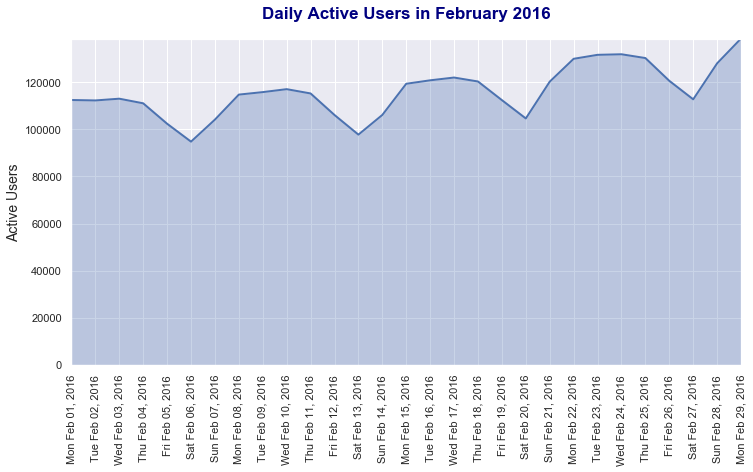

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.plot(xdata, ydata, lw=2)
ax.fill_between(xdata, 0, ydata, alpha=0.3)
ax.set(xlim=(xdata[0],xdata[-1]))
ax.set(ylim=(0,max(ydata)))

ax.set_xticks(xdata)
ax.set_xticklabels(xdata, rotation=90)

ylabel = ax.set_ylabel('Active Users')
ylabel.set_size(14)

ttl = ax.set_title('Daily Active Users in February 2016', pad=20)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)

### 2 - Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, Feb 10th, and Feb 14th.  Also, show the number of users from each cohort
- Daily retention curve is defined as the % of users from the cohort, who used the product that day

#### Number of the users from each cohort
1. Define 3 filters for the users who use the app for the first time on those 3 days: `feb04_filter`, `feb10_filter`, and `feb14_filter`
2. Add a new column `cohort` to the `df` DataFrame to indicate whether a user uses the app for the first time on Feb04, Feb10, Feb14, or Other
3. Compute the number of users from each cohort
  - Select only `uid` and `cohort`
  - Group the data by `cohort`
  - Count the unique `uid`
  
| Cohort      |Number of Users|
|:-------------|-------------:|
| February-4  |2735|
| February-10 |3129|
| February-14 |2761|


In [9]:
feb04_filter = (df['date']=='2016-02-04') & (df['isFirst']==True)
feb10_filter = (df['date']=='2016-02-10') & (df['isFirst']==True)
feb14_filter = (df['date']=='2016-02-14') & (df['isFirst']==True)

df['cohort'] = np.where(df['uid'].isin(df[feb04_filter]['uid']), 
                        'Feb04', 
                        np.where(df['uid'].isin(df[feb10_filter]['uid']),
                                 'Feb10',
                                 np.where(df['uid'].isin(df[feb14_filter]['uid']),
                                          'Feb14',
                                          'Other')))

In [10]:
users_in_cohort = df[['uid','cohort']].groupby('cohort')[['uid']].nunique()
users_in_cohort

,uid
cohort,
Feb04,2735
Feb10,3129
Feb14,2761
Other,238215


#### Calculate the daily retention curve
- Copy the data of interest (`date`,`uid`, and `cohort`) to a new DataFrame `retention_df`
- A user who uses the product multiple times a day is counted as one user
  - Multiple rows having the same user on a given day is counted as one
  - Therefore, drop duplicates of `date` & `uid` 
- Daily retention calculation
  1. Group the data by `date`
  2. Compute the percentage of the `cohort`
  3. `unstack` to present the results in tabular format
<br><br>
- **Data Validation:** The `cohort` of Feb04, Feb10, and Feb14 starts on 2016-02-04, 2016-02-10, and 2016-02-14, respectively

In [11]:
retention_df = df[['date', 'uid', 'cohort']].copy()
retention_df.drop_duplicates(subset=['date','uid'], inplace=True)

In [12]:
retention_curve = retention_df.groupby('date')['cohort'].value_counts(normalize=True).unstack()
retention_curve

cohort,Feb04,Feb10,Feb14,Other
date,,,,
2016-02-01,NaN,NaN,NaN,1.000000
2016-02-02,NaN,NaN,NaN,1.000000
2016-02-03,NaN,NaN,NaN,1.000000
2016-02-04,0.024618,NaN,NaN,0.975382
2016-02-05,0.014548,NaN,NaN,0.985452
2016-02-06,0.012678,NaN,NaN,0.987322
2016-02-07,0.012153,NaN,NaN,0.987847
2016-02-08,0.011437,NaN,NaN,0.988563
2016-02-09,0.010409,NaN,NaN,0.989591


#### Plot the retention curve of the cohorts as the percentage of the users
- **Observation:** The cohorts are only a slight percentage of all users

In [13]:
retention_curve = retention_curve.loc[:, ::-1]

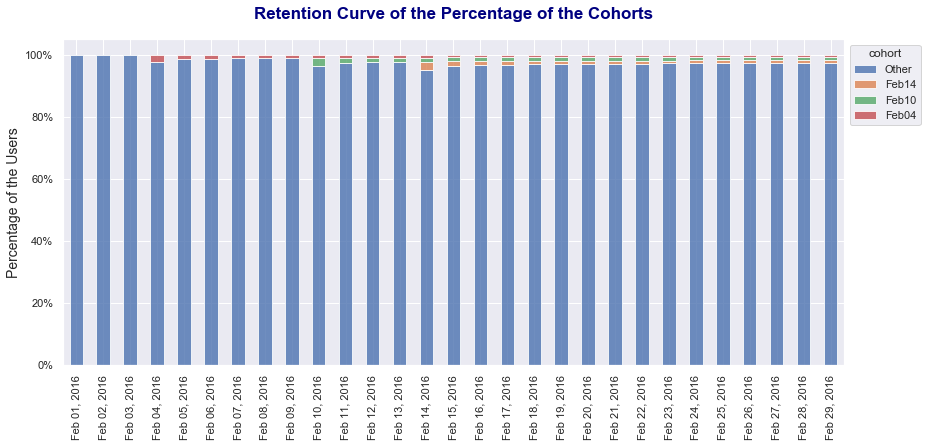

In [14]:
ax = retention_curve.plot(kind='bar', stacked=True, figsize=(14, 6), alpha=0.8)
ax.legend(title='cohort', bbox_to_anchor=(1.0, 1), loc='upper left');

ax.set_xticklabels(retention_curve.index.strftime('%b %d, %Y'))
ax.axes.get_xaxis().get_label().set_visible(False)

ax.set_yticklabels(['{:.0%}'.format(y) for y in ax.get_yticks()])
ylabel = ax.set_ylabel('Percentage of the Users')
ylabel.set_size(14)

ttl = ax.set_title('Retention Curve of the Percentage of the Cohorts', pad=20)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)

#### Plot the retention curve of the 3 cohorts in February 2016
- **Observations** 
  - All 3 cohorts have the same pattern 
  - Their active users sharply drop the next day and gradually decrease afterwards

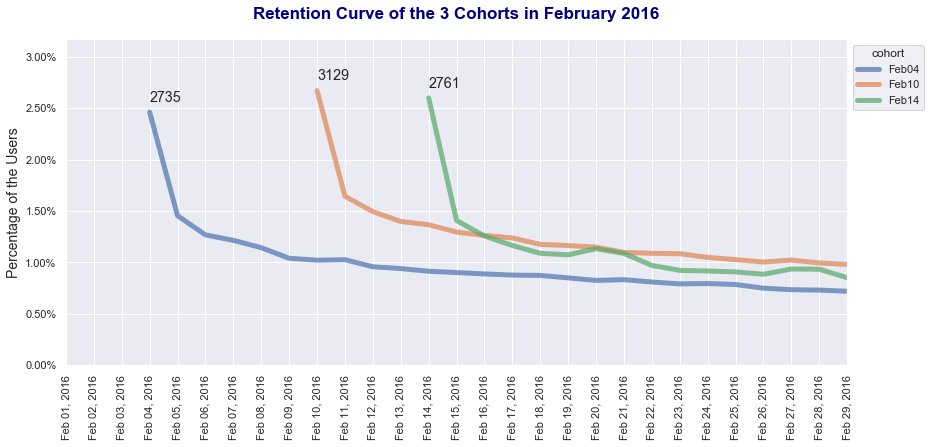

In [15]:
ax = retention_curve[['Feb04','Feb10','Feb14']].plot(figsize=(14, 6), lw=5, alpha=0.7)
ax.legend(title='cohort', bbox_to_anchor=(1.0, 1), loc='upper left');

ax.text('2016-02-04', retention_curve.loc['2016-02-04', 'Feb04'] + 0.001, \
        users_in_cohort.loc['Feb04']['uid'], size='large')
ax.text('2016-02-10', retention_curve.loc['2016-02-10', 'Feb10'] + 0.001, \
        users_in_cohort.loc['Feb10']['uid'], size='large')
ax.text('2016-02-14', retention_curve.loc['2016-02-14', 'Feb14'] + 0.001, \
        users_in_cohort.loc['Feb14']['uid'], size='large')

ax.set_xticks(retention_curve.index.strftime('%b %d, %Y'))
ax.set_xticklabels(retention_curve.index.strftime('%b %d, %Y'), rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ax.set(ylim=(0, np.nanmax(retention_curve[['Feb04','Feb10','Feb14']].values) + 0.005 ))
ax.set_yticklabels(['{:.2%}'.format(y) for y in ax.get_yticks()])
ylabel = ax.set_ylabel('Percentage of the Users')
ylabel.set_size(14)

ttl = ax.set_title('Retention Curve of the 3 Cohorts in February 2016', pad=20)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)

### 3 - Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users?
- Copy the data of interest (`date`,`uid`, and `utmSource`) to a new DataFrame `utmsource_df`
- 34.7% of `utmSource` is None
- Drop the data where `utmSource` is None because the traffic source cannot be determined

In [16]:
utmsource_df = df[['date', 'uid', 'utmSource']].copy()
utmsource_df.isna().mean()

date         0.000000
uid          0.000000
utmSource    0.347126
dtype: float64

In [17]:
utmsource_df.dropna(axis='rows', subset=['utmSource'], inplace=True)
utmsource_df.head(3)

,date,uid,utmSource
0,2016-02-29,g4Hjpoji4dmv,Biznesowe+Rewolucje
1,2016-02-29,g4Hjpoji4dmv,Biznesowe+Rewolucje
2,2016-02-29,75121338,program


#### Plot the bar chart of usage from each source
- Contrary to Questions 1 and 2, a user opening the app *n* times a days, will be counted *n* times
- Therefore, do **not** drop the duplicates of `date`, `uid`, and `utmSource`
<br><br>
- **Observations**
  - There are differences in usage based on where the users came from
  - Most usage (56.53%) comes from the traffic source `Biznesowe+Rewolucje`
  - The usage from top-6 sources made up of 91.23% usage
    - `iznesowe+Rewolucje`
    - `program`
    - `answers`
    - `shmoop_left`
    - `twitter`
    - `MosaLingua+FR`

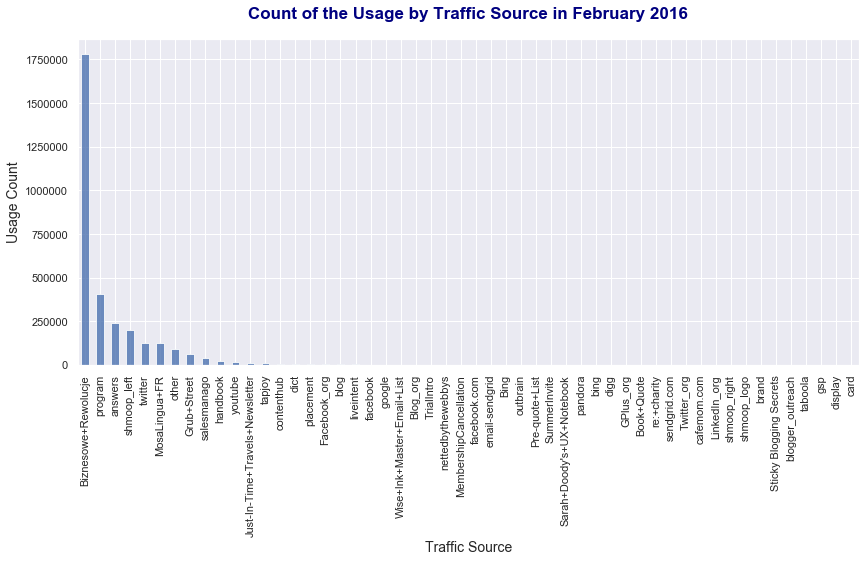

In [18]:
ax = utmsource_df['utmSource'].value_counts().plot(kind='bar', figsize=(14,6), alpha=0.8)

xlabel = ax.set_xlabel('Traffic Source')
xlabel.set_size(14)

ylabel = ax.set_ylabel('Usage Count')
ylabel.set_size(14)

ttl = ax.set_title('Count of the Usage by Traffic Source in February 2016', pad=20)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)

In [19]:
utmsource_df['utmSource'].value_counts().to_frame(name='Usage Count')

,Usage Count
Biznesowe+Rewolucje,1780384
program,405199
answers,238064
shmoop_left,198620
twitter,127657
MosaLingua+FR,123116
other,88440
Grub+Street,61094
salesmanago,37729
handbook,22178


In [20]:
top_usage = utmsource_df['utmSource'].value_counts().loc['Biznesowe+Rewolucje'].sum()\
              /utmsource_df['utmSource'].value_counts().sum()
print(f'Majority of the usage ({100*top_usage:.2f}%) comes from the traffic source Biznesowe+Rewolucje')

Majority of the usage (56.53%) comes from the traffic source Biznesowe+Rewolucje


In [21]:
top_6_usage = utmsource_df['utmSource'].value_counts().loc['Biznesowe+Rewolucje':'MosaLingua+FR'].sum()\
                /utmsource_df['utmSource'].value_counts().sum()
print(f'The usage from top-6 sources made up of {100*top_6_usage:.2f}% usage')

The usage from top-6 sources made up of 91.23% usage


#### Best users and worst users
- Let quantify "*best user*" and "*worst user*" based on how often the users open the app within a given timeframe (i.e., February 2016)
  - For example, in Febuary 2016, a user who opens the app 10 times is better than another user who opens the app 1 time
<br><br>
- **Note:** There are other metrics that can be used to quantify the users
  - Metric 1 - Compute the number of days a user opens the app
    - For example, a user who opens the app 1 time on February 1 and February 2 is better than another users who opens the app 2 times on February 1 because the first user revisits the app more often
  - Metric 2 - Compute the score of the number of days and how often a user opens the app
    - For example, a user gets 5 points on any day he opens the app and gets 1 point for each app open
    - If a user opens the app 1 time on February 1 and February 2, he will get (5+1)+(5+1) = 12 points
    - If another user opens the app 10 times on February 1, he will get (5+1\*10) = 15 points and is considered a better user
  - In this analysis, we will stick with the first metric, which counts the number of app opens in February 2016
<br><br>
- **Calculate which traffic sources the app gets its best user and worst user**
  - Group the data by `utmSource`
  - Count `uid` to get Total Usages by traffic sources
  - Count unique `uid` to get Total Users by traffic sources
  - Compute $\frac{\ Total \ Usages}{\ Total \ Users}$ to get Usage Ratio by traffic sources
  - Plot the Usage Ratio vs. traffic sources
  <br><br>
  - **Note:** Include only the traffice sources `source_filter` that have *at least 100 unique users*
    - This is to exclude outliers, for example, where there is only 1 user from a traffic source and that user uses the app 75 times in February 2016.  In this example, the usage of 75 times may not generalize well for additional users that will come from that source in the future
    - 100 is an arbitrary number and can be adjusted
<br><br>    
- **Observations:** Based on the above assumptions, the best users are from "**contenthub**" and the worst users are from "**answers**"

In [22]:
is_unique_100 = (utmsource_df.groupby(['utmSource'])['uid'].agg(['nunique']) > 100)
source_filter = is_unique_100[is_unique_100['nunique']==True].index
source_filter

Index(['Biznesowe+Rewolucje', 'Grub+Street', 'Just-In-Time+Travels+Newsletter',
       'MosaLingua+FR', 'answers', 'contenthub', 'dict', 'handbook', 'other',
       'placement', 'program', 'salesmanago', 'shmoop_left', 'tapjoy',
       'twitter', 'youtube'],
      dtype='object', name='utmSource')

In [23]:
target_utmsource_df = utmsource_df[utmsource_df['utmSource'].isin(source_filter)].groupby(['utmSource'])\
                        ['uid'].agg(['count','nunique'])
target_utmsource_df['usage_ratio'] = target_utmsource_df['count']/target_utmsource_df['nunique']
target_utmsource_df.sort_values(by=['usage_ratio'], ascending=False)

,count,nunique,usage_ratio
utmSource,,,
contenthub,7066,182,38.824176
salesmanago,37729,1122,33.626560
tapjoy,11517,347,33.190202
youtube,13679,458,29.866812
shmoop_left,198620,6913,28.731376
Grub+Street,61094,2431,25.131222
twitter,127657,5151,24.782955
program,405199,16493,24.567938
Just-In-Time+Travels+Newsletter,11560,515,22.446602


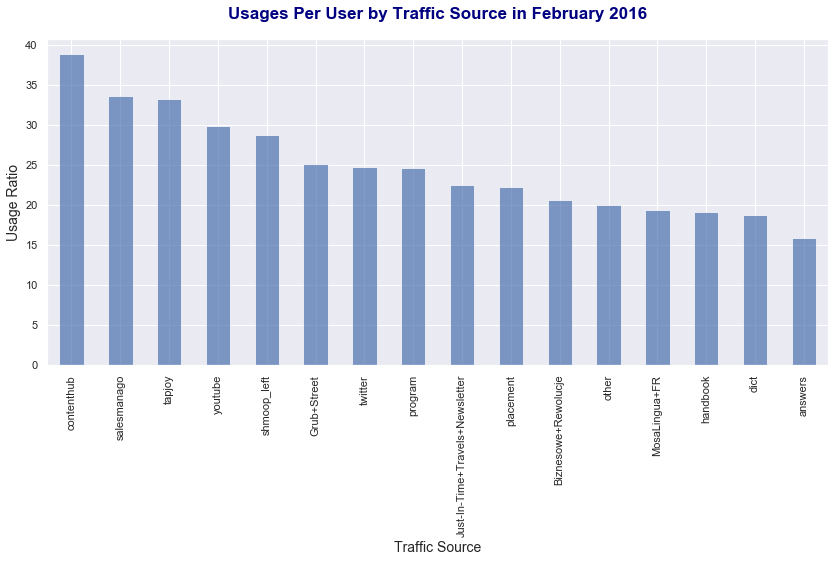

In [24]:
ax = target_utmsource_df['usage_ratio'].sort_values(ascending=False)\
       .plot(kind='bar', figsize=(14,6), alpha=0.7)

xlabel = ax.set_xlabel('Traffic Source')
xlabel.set_size(14)

ylabel = ax.set_ylabel('Usage Ratio')
ylabel.set_size(14)

ttl = ax.set_title('Usages Per User by Traffic Source in February 2016', pad=20)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)